<a href="https://colab.research.google.com/github/Afealete/FOXTROT-2-ASSIGNMENT-2/blob/main/Group%204%20(FOXTROT-2)%20Project%20One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study – Banking & Loans in Ghana

In today’s competitive and digitally driven financial environment, the ability to predict credit risk is a strategic advantage. GhanaLoanConnect, a digital lending platform connecting borrowers to investors, is actively seeking data-driven solutions to reduce its rate of non-performing loans (NPLs). Rising default rates not only impact profitability but also weaken lender trust and reduce platform credibility

To address this challenge, this project proposes the development of a machine learning model that can predict the likelihood of a borrower defaulting on a loan. With accurate predictions, GhanaLoanConnect can proactively minimize risk, prioritize low-risk borrowers, and enhance portfolio performance.

## Import common libraries

In [67]:
!pip install fairlearn

In [68]:
!pip install scikit-optimize

In [69]:
# to handle the data
import pandas as pd
import numpy as np

# to visualize the data
import matplotlib.pyplot as plt
import seaborn as sns

# To preprocess the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder,OneHotEncoder

# machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score

# for classification tasks
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


# metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#import fairlearn for fairness assessment and mitigation
from fairlearn.metrics import MetricFrame,demographic_parity_difference,equalized_odds_difference
from fairlearn.reductions import GridSearch,EqualizedOdds #Using EqualizedOdds as constraint


## Load dataset

In [70]:
# Reading the dataset into the content folder
from google.colab import files
uploaded = files.upload()


data = pd.read_csv('/content/loan_borowwer_data.csv')
data



# 1. Define the sensitive attribute(s)
sensitive_attribute_name = 'fico' # Name for printing
A = data[[sensitive_attribute_name]] # Extract the sensitive attribute column(s)

# Exclude sensitive attribute from features
X = data.drop(['not.fully.paid', sensitive_attribute_name], axis=1)
y = data['not.fully.paid']

Saving loan_borowwer_data.csv to loan_borowwer_data (6).csv


# 1.Exploratory Data Analysis


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [72]:
data.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


In [73]:
# Check for missing values
print(data.isnull().sum())

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64


not.fully.paid
0    8045
1    1533
Name: count, dtype: int64


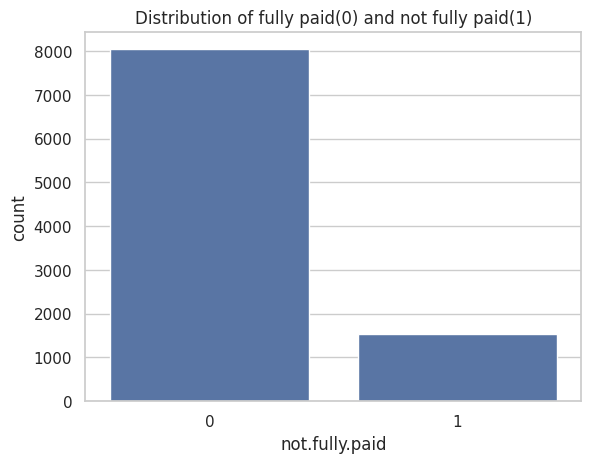

In [74]:
#count of fully paid and not fully paid clients
print(data['not.fully.paid'].value_counts())
# Visualize the distribution of the target variable (credit.policy)
sns.countplot(x='not.fully.paid', data=data)
plt.title('Distribution of fully paid(0) and not fully paid(1)')
plt.show()

## 2. Data Preprocessing

In [75]:
# One hot encoding for 'purpose' since is the only one with strings
data = pd.get_dummies(data, columns=['purpose'], drop_first=True)

# Verify the changes
data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,False,True,False,False,False,False
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,True,False,False,False,False,False
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,False,True,False,False,False,False
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,False,True,False,False,False,False
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,True,False,False,False,False,False


Distribution of not fully paid:
not.fully.paid
0    8045
1    8045
Name: count, dtype: int64


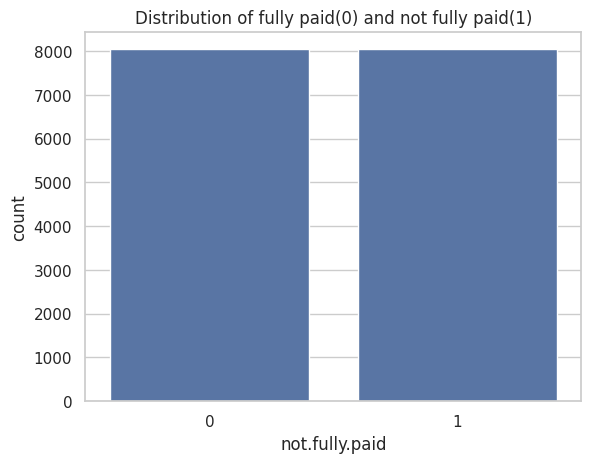

In [76]:
# Scaling to get equal distributions
from imblearn.over_sampling import RandomOverSampler

# Separate features and target
X = data.drop('not.fully.paid', axis=1)
y = data['not.fully.paid']

# Instantiate RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the training data
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine the oversampled minority class with the majority class
data_balanced = pd.concat([X_resampled, y_resampled])

# Display the new distribution
print("Distribution of not fully paid:")
print(y_resampled.value_counts())

# Visualizing the new distribution
sns.countplot(x=y_resampled)
plt.title('Distribution of fully paid(0) and not fully paid(1)')
plt.show()

([<matplotlib.patches.Wedge at 0x7a2975165b50>,
 [Text(-0.9638470616227687, 0.5300932387808346, '0'),
  Text(0.9638471079649895, -0.5300931545186429, '1')],
 [Text(-0.5257347608851465, 0.28914176660772795, '84.0%'),
  Text(0.5257347861627215, -0.2891417206465325, '16.0%')])

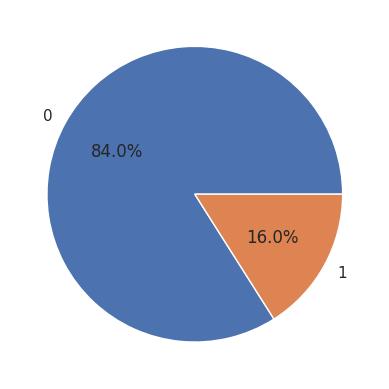

In [77]:
pct_defaulters = data['not.fully.paid'].value_counts(normalize=True)
plt.pie(pct_defaulters, labels=pct_defaulters.index, autopct='%1.1f%%')

## 3. Feature Engineering

In [78]:
# Debt-to-Income Ratio (DTI)
data["debt_to_income_ratio"] = data["installment"] / data["log.annual.inc"]

#Loan-to-income Ratio
data["loan_to_income"] = data["installment"] / np.exp(data["log.annual.inc"])

# Credit Utilization Ratio
data["credit_utilization"] = data["revol.bal"] / data["revol.util"]

# Payment-to-Income Ratio
data["payment_to_income_ratio"] = data["installment"] / data["log.annual.inc"]

# Check newly created features
print(data.head())


   credit.policy  int.rate  installment  log.annual.inc    dti  fico  \
0              1    0.1189       829.10       11.350407  19.48   737   
1              1    0.1071       228.22       11.082143  14.29   707   
2              1    0.1357       366.86       10.373491  11.63   682   
3              1    0.1008       162.34       11.350407   8.10   712   
4              1    0.1426       102.92       11.299732  14.97   667   

   days.with.cr.line  revol.bal  revol.util  inq.last.6mths  ...  \
0        5639.958333      28854        52.1               0  ...   
1        2760.000000      33623        76.7               0  ...   
2        4710.000000       3511        25.6               1  ...   
3        2699.958333      33667        73.2               1  ...   
4        4066.000000       4740        39.5               0  ...   

   purpose_credit_card  purpose_debt_consolidation  purpose_educational  \
0                False                        True                False   
1       

In [79]:
data.isnull().sum()

,0
credit.policy,0
int.rate,0
installment,0
log.annual.inc,0
dti,0
fico,0
days.with.cr.line,0
revol.bal,0
revol.util,0
inq.last.6mths,0


In [80]:
data.fillna(data.median(), inplace=True)
data.isnull().sum()

,0
credit.policy,0
int.rate,0
installment,0
log.annual.inc,0
dti,0
fico,0
days.with.cr.line,0
revol.bal,0
revol.util,0
inq.last.6mths,0


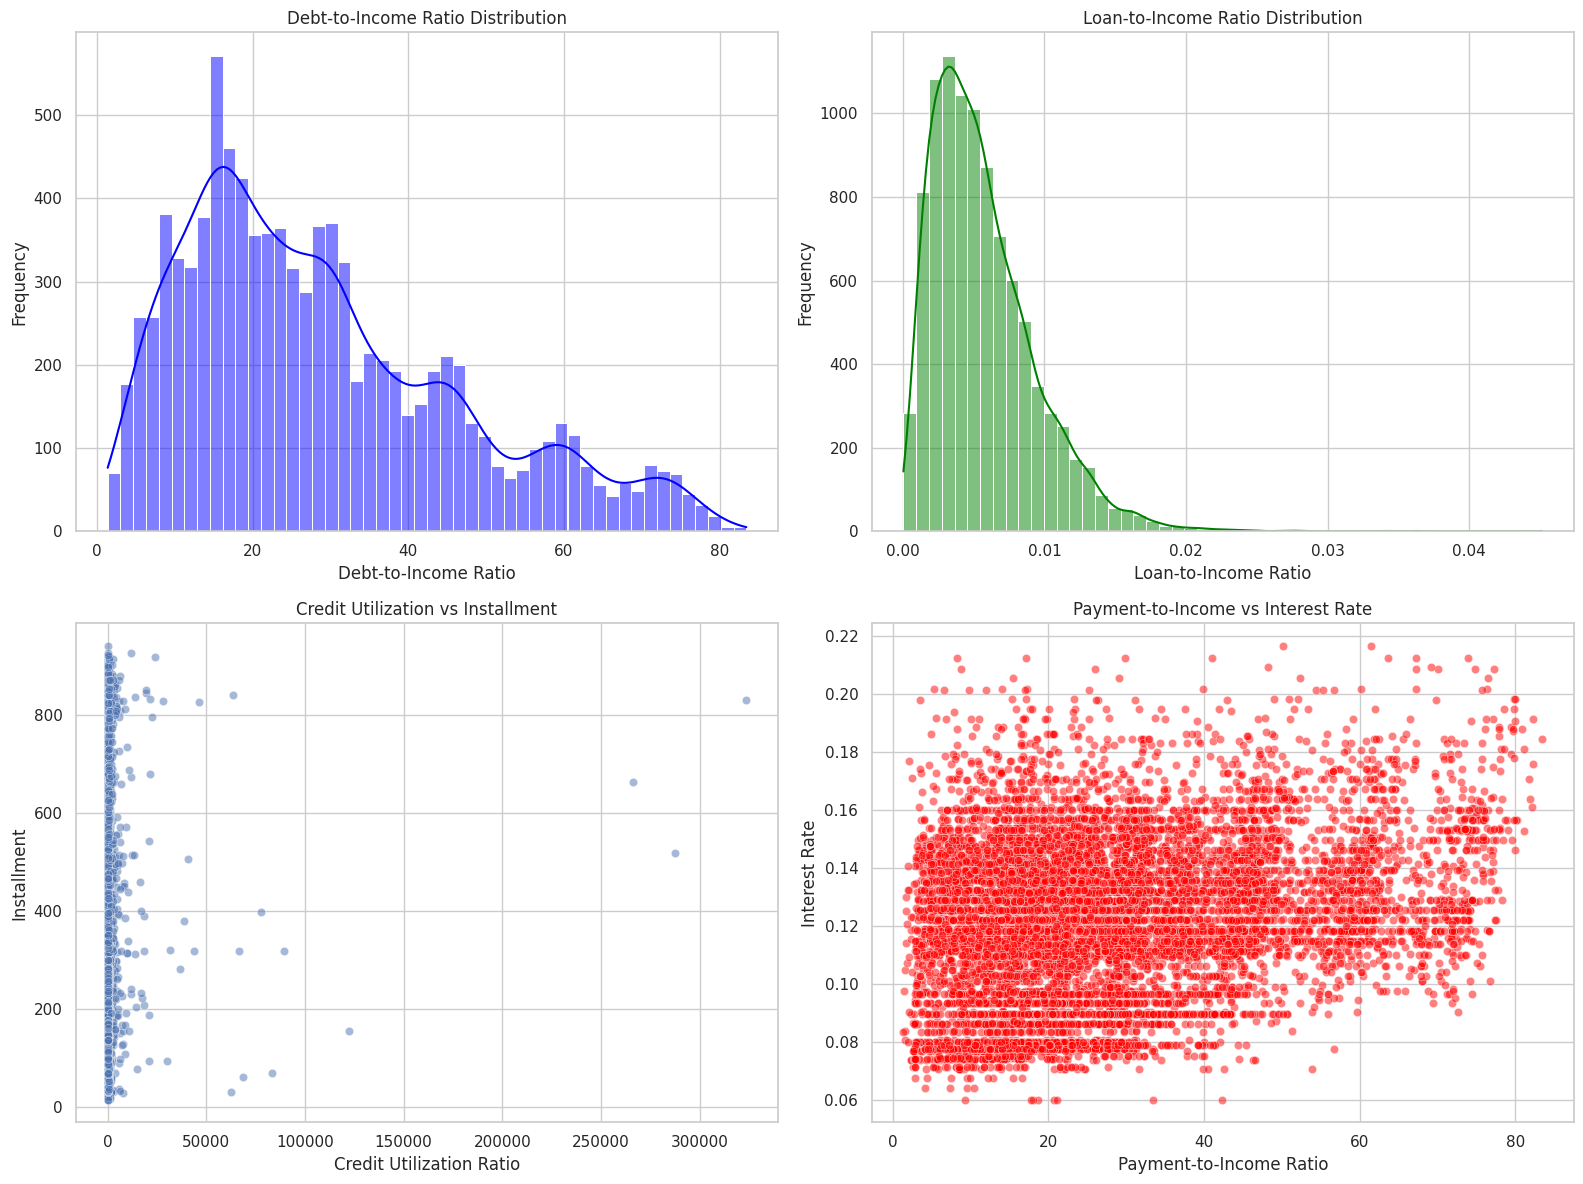

Debt-to-Income Analysis:
This histogram shows how much of a borrower's income is allocated to debt payments. A right-skewed distribution means most borrowers have lower debt-to-income ratios, but outliers with high values may indicate financial strain, increasing their risk of default.

Loan-to-Income Analysis:
This histogram visualizes the ratio of loan amounts relative to income. A high loan-to-income ratio indicates riskier borrowers who may struggle with repayments. A bell-shaped distribution suggests normal loan behavior, while a long tail indicates potential defaults.

Credit Utilization Analysis:
This scatter plot shows the relationship between credit utilization and installment amounts. A higher credit utilization ratio often means borrowers rely heavily on credit, which may signal financial distress. If we see a concentration of high utilization ratios with large installment payments, it may indicate defaulters.

Payment-to-Income Analysis:
This scatter plot compares the borro

In [81]:
# Visualization style
sns.set(style="whitegrid")
plt.figure(figsize=(16, 12))

# **1. Debt-to-Income Ratio Distribution**
plt.subplot(2, 2, 1)
sns.histplot(data["debt_to_income_ratio"], bins=50, kde=True, color="blue")
plt.title("Debt-to-Income Ratio Distribution")
plt.xlabel("Debt-to-Income Ratio")
plt.ylabel("Frequency")

# **2. Loan-to-Income Ratio Distribution**
plt.subplot(2, 2, 2)
sns.histplot(data["loan_to_income"], bins=50, kde=True, color="green")
plt.title("Loan-to-Income Ratio Distribution")
plt.xlabel("Loan-to-Income Ratio")
plt.ylabel("Frequency")

# **3. Credit Utilization Ratio Scatter Plot vs Loan Amount**
plt.subplot(2, 2, 3)
sns.scatterplot(x=data["credit_utilization"], y=data["installment"], alpha=0.5)
plt.title("Credit Utilization vs Installment")
plt.xlabel("Credit Utilization Ratio")
plt.ylabel("Installment")

# **4. Payment-to-Income Ratio Scatter Plot vs Interest Rate**
plt.subplot(2, 2, 4)
sns.scatterplot(x=data["payment_to_income_ratio"], y=data["int.rate"], alpha=0.5, color="red")
plt.title("Payment-to-Income vs Interest Rate")
plt.xlabel("Payment-to-Income Ratio")
plt.ylabel("Interest Rate")


plt.tight_layout()
plt.show()

def explain_visualizations(data):
    insights = {}

    # **1. Debt-to-Income Ratio Distribution**
    insights["Debt-to-Income"] = (
        "This histogram shows how much of a borrower's income is allocated to debt payments. "
        "A right-skewed distribution means most borrowers have lower debt-to-income ratios, but outliers with high values "
        "may indicate financial strain, increasing their risk of default."
    )

    # **2. Loan-to-Income Ratio Distribution**
    insights["Loan-to-Income"] = (
        "This histogram visualizes the ratio of loan amounts relative to income. "
        "A high loan-to-income ratio indicates riskier borrowers who may struggle with repayments. "
        "A bell-shaped distribution suggests normal loan behavior, while a long tail indicates potential defaults."
    )

    # **3. Credit Utilization Ratio Scatter Plot**
    insights["Credit Utilization"] = (
        "This scatter plot shows the relationship between credit utilization and installment amounts. "
        "A higher credit utilization ratio often means borrowers rely heavily on credit, which may signal financial distress. "
        "If we see a concentration of high utilization ratios with large installment payments, it may indicate defaulters."
    )

    # **4. Payment-to-Income Ratio Scatter Plot**
    insights["Payment-to-Income"] = (
        "This scatter plot compares the borrower's loan payments against their interest rate. "
        "Borrowers with high payment-to-income ratios and high-interest rates could be at higher risk of default. "
        "If the plot shows an upward trend, it suggests that higher payments correlate with higher interest rates."
    )

    return insights


# Call the function and display explanations
explanations = explain_visualizations(data)
for key, value in explanations.items():
    print(f"{key} Analysis:\n{value}\n")



In [84]:
# Debt-to-Income Ratio (DTI)
data["debt_to_income_ratio"] = data["installment"] / data["log.annual.inc"]

#Loan-to-income Ratio
data["loan_to_income"] = data["installment"] / np.exp(data["log.annual.inc"])

# Credit Utilization Ratio
# Handle potential division by zero that would result in infinity
# Replace 0 in 'revol.util' with a small non-zero value or handle based on domain knowledge
# For now, let's add a small epsilon to avoid division by zero
epsilon = 1e-6
data["credit_utilization"] = data["revol.bal"] / (data["revol.util"] + epsilon)

# Payment-to-Income Ratio
data["payment_to_income_ratio"] = data["installment"] / data["log.annual.inc"]

# Check newly created features
print(data.head())

# Check for and handle infinite values
print("\nChecking for infinite values before filling...")
print(data.replace([np.inf, -np.inf], np.nan).isnull().sum()) # Temporarily replace inf with NaN to count

# Replace infinite values with NaN and then fill NaNs (which now include infinities) with median
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.median(), inplace=True)

# Verify that there are no more missing or infinite values
print("\nChecking for missing values after filling (should be 0):")
print(data.isnull().sum())

from fairlearn.metrics import MetricFrame,demographic_parity_difference,equalized_odds_difference
from fairlearn.reductions import GridSearch,EqualizedOdds #Using EqualizedOdds as constraint
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler # Import RandomOverSampler

# Separate features and target
X = data.drop('not.fully.paid', axis=1)
y = data['not.fully.paid']


# Resample the data (already done in the provided code using RandomOverSampler)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Scale or normalize features
# Using StandardScaler as it is generally suitable for most algorithms.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for easier handling (optional but good practice)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

   credit.policy  int.rate  installment  log.annual.inc    dti  fico  \
0              1    0.1189       829.10       11.350407  19.48   737   
1              1    0.1071       228.22       11.082143  14.29   707   
2              1    0.1357       366.86       10.373491  11.63   682   
3              1    0.1008       162.34       11.350407   8.10   712   
4              1    0.1426       102.92       11.299732  14.97   667   

   days.with.cr.line  revol.bal  revol.util  inq.last.6mths  ...  \
0        5639.958333      28854        52.1               0  ...   
1        2760.000000      33623        76.7               0  ...   
2        4710.000000       3511        25.6               1  ...   
3        2699.958333      33667        73.2               1  ...   
4        4066.000000       4740        39.5               0  ...   

   purpose_credit_card  purpose_debt_consolidation  purpose_educational  \
0                False                        True                False   
1       

Training Logistic Regression...
Logistic Regression Evaluation Complete.

Training Decision Tree...
Decision Tree Evaluation Complete.

Training Random Forest...
Random Forest Evaluation Complete.

Training XGBoost...
XGBoost Evaluation Complete.

Training Gradient Boosting...
Gradient Boosting Evaluation Complete.

Model Performance Metrics:
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.632380   0.639216  0.607831  0.623128  0.693780
Decision Tree        0.897763   0.833681  0.993785  0.906720  0.897763
Random Forest        0.976072   0.962560  0.990677  0.976417  0.997699
XGBoost              0.891548   0.861239  0.933499  0.895914  0.962847
Gradient Boosting    0.673710   0.676118  0.666874  0.671464  0.747057

The best model based on ROC AUC is: Random Forest


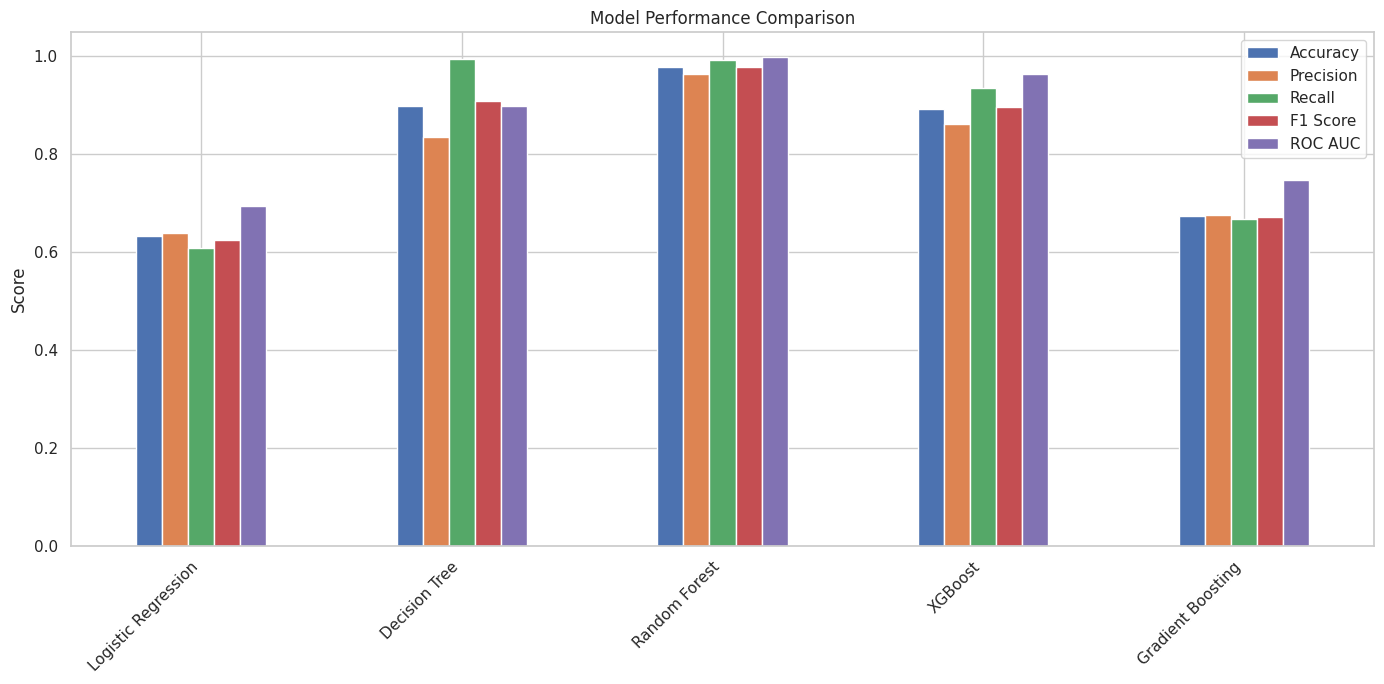

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] # Probability for the positive class

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    print(f"{name} Evaluation Complete.\n")

# Display results in a DataFrame
results_df = pd.DataFrame(results).T
print("Model Performance Metrics:")
print(results_df)

# Determine the best model based on a chosen metric (e.g., ROC AUC)
best_model_name = results_df['ROC AUC'].idxmax()
print(f"\nThe best model based on ROC AUC is: {best_model_name}")

# Optional: Visualize the results
results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']].plot(kind='bar', figsize=(14, 7))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



Confusion Matrices:

Logistic Regression Confusion Matrix:
[[1057  552]
 [ 631  978]]


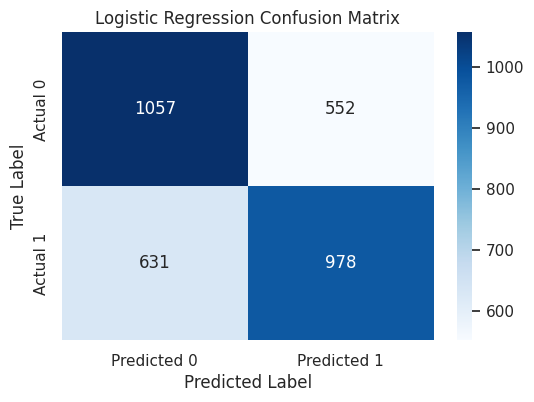


Decision Tree Confusion Matrix:
[[1290  319]
 [  10 1599]]


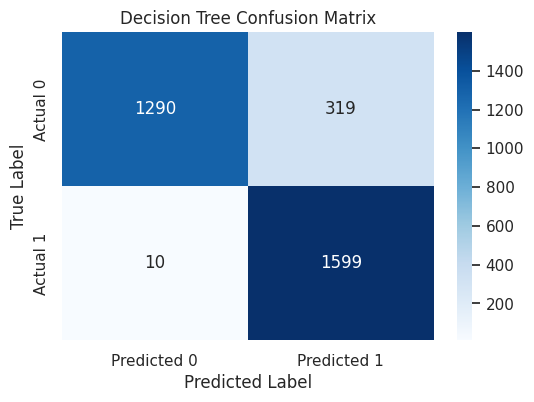


Random Forest Confusion Matrix:
[[1547   62]
 [  15 1594]]


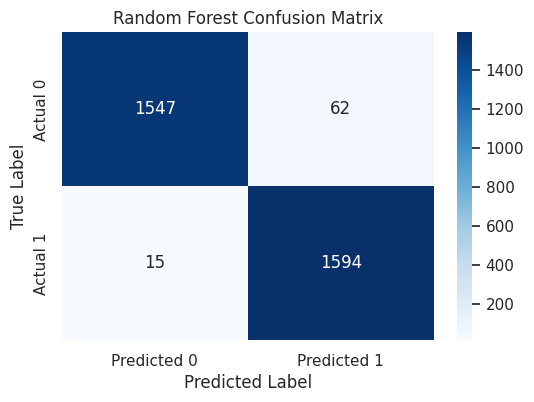


XGBoost Confusion Matrix:
[[1367  242]
 [ 107 1502]]


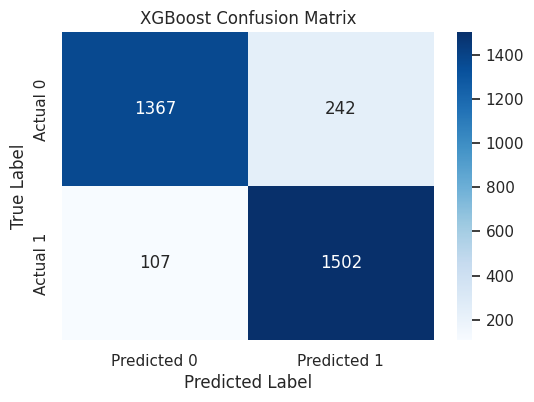


Gradient Boosting Confusion Matrix:
[[1095  514]
 [ 536 1073]]


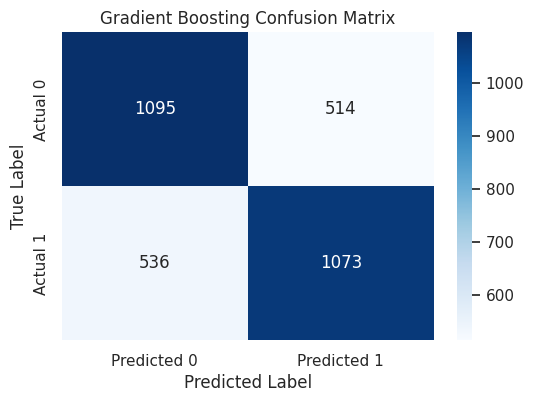


Classification Reports:

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64      1609
           1       0.64      0.61      0.62      1609

    accuracy                           0.63      3218
   macro avg       0.63      0.63      0.63      3218
weighted avg       0.63      0.63      0.63      3218


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      1609
           1       0.83      0.99      0.91      1609

    accuracy                           0.90      3218
   macro avg       0.91      0.90      0.90      3218
weighted avg       0.91      0.90      0.90      3218


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1609
           1       0.96      0.99      0.98      1609

    accuracy                         

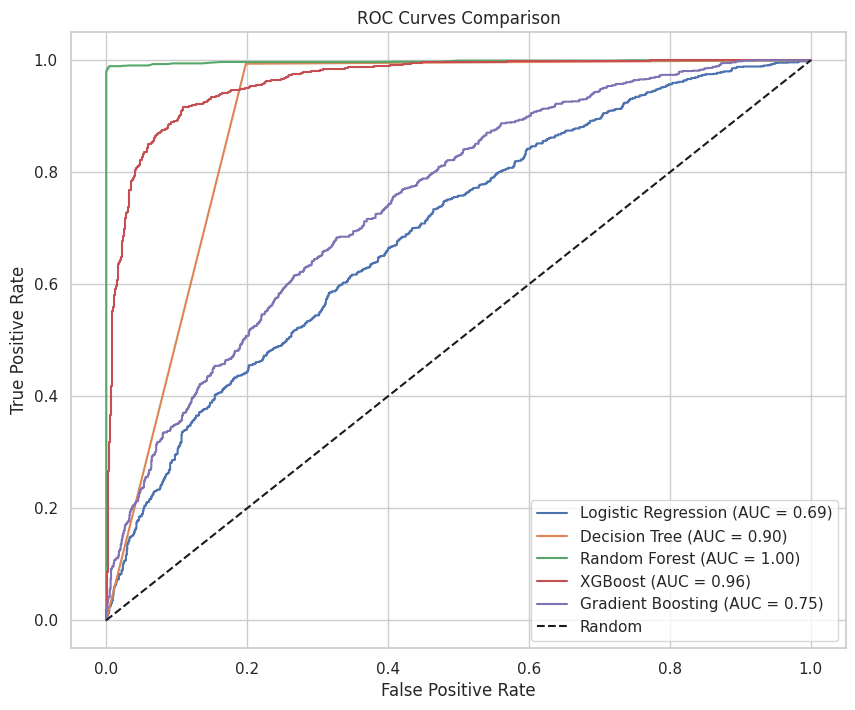


Performing Cross-Validation for the best model: Random Forest
Cross-validation ROC AUC scores: [0.98524483 0.9906971  0.98471325 0.98920198 0.99017822]
Mean cross-validation ROC AUC: 0.9880
Standard deviation of cross-validation ROC AUC: 0.0025

Feature Importance:

Decision Tree Feature Importance:
int.rate                      0.128885
log.annual.inc                0.100375
revol.bal                     0.093484
dti                           0.089348
loan_to_income                0.089294
revol.util                    0.088913
days.with.cr.line             0.082091
fico                          0.056277
credit_utilization            0.040854
installment                   0.040571
payment_to_income_ratio       0.037267
debt_to_income_ratio          0.036514
inq.last.6mths                0.033566
credit.policy                 0.024637
delinq.2yrs                   0.013388
pub.rec                       0.009673
purpose_debt_consolidation    0.009137
purpose_credit_card           0.007

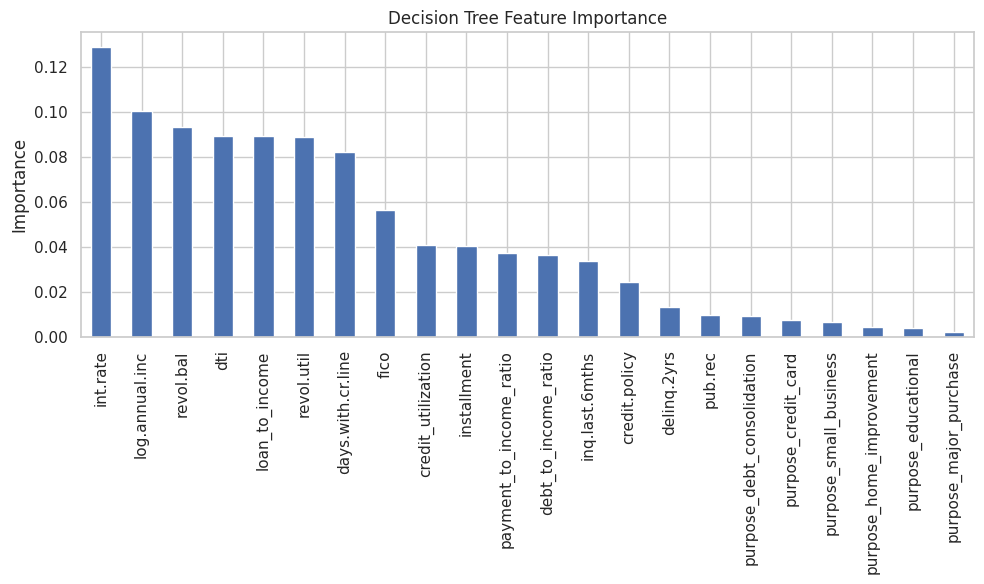


Random Forest Feature Importance:
int.rate                      0.090594
days.with.cr.line             0.081303
loan_to_income                0.078424
log.annual.inc                0.077670
dti                           0.077377
revol.util                    0.077243
revol.bal                     0.075236
installment                   0.066964
payment_to_income_ratio       0.066611
fico                          0.065934
debt_to_income_ratio          0.065820
credit_utilization            0.059105
inq.last.6mths                0.042014
credit.policy                 0.018813
purpose_debt_consolidation    0.011511
delinq.2yrs                   0.010357
purpose_credit_card           0.007883
purpose_small_business        0.007693
pub.rec                       0.006289
purpose_home_improvement      0.004872
purpose_major_purchase        0.004393
purpose_educational           0.003894
dtype: float64


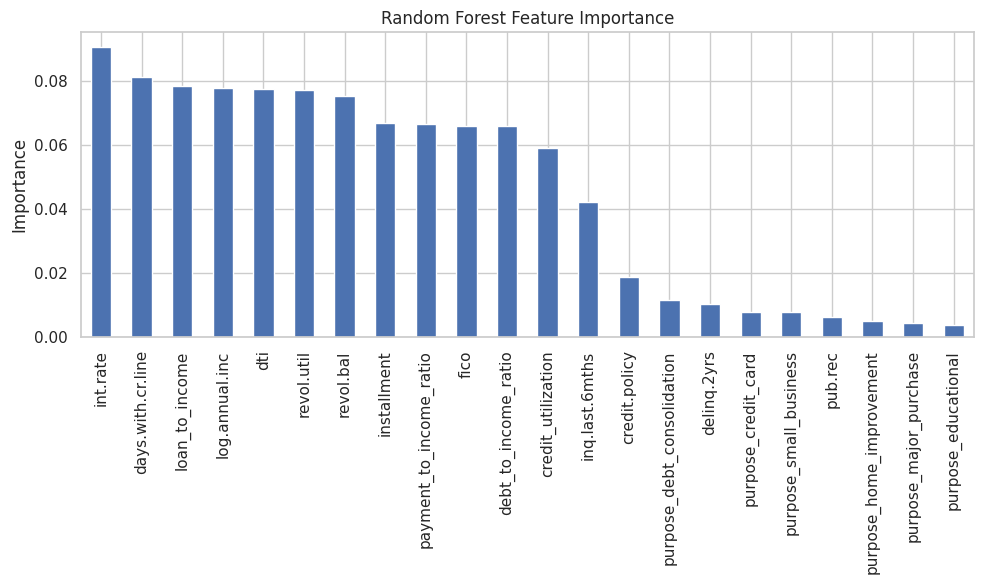


XGBoost Feature Importance:
credit.policy                 0.166744
int.rate                      0.057883
purpose_small_business        0.055984
purpose_credit_card           0.050152
pub.rec                       0.049326
purpose_major_purchase        0.045111
log.annual.inc                0.042728
purpose_educational           0.042200
debt_to_income_ratio          0.041706
revol.util                    0.040828
inq.last.6mths                0.040422
loan_to_income                0.039841
dti                           0.038781
credit_utilization            0.038759
days.with.cr.line             0.038408
fico                          0.038324
revol.bal                     0.037074
purpose_debt_consolidation    0.037009
installment                   0.036179
delinq.2yrs                   0.032714
purpose_home_improvement      0.029824
payment_to_income_ratio       0.000000
dtype: float32


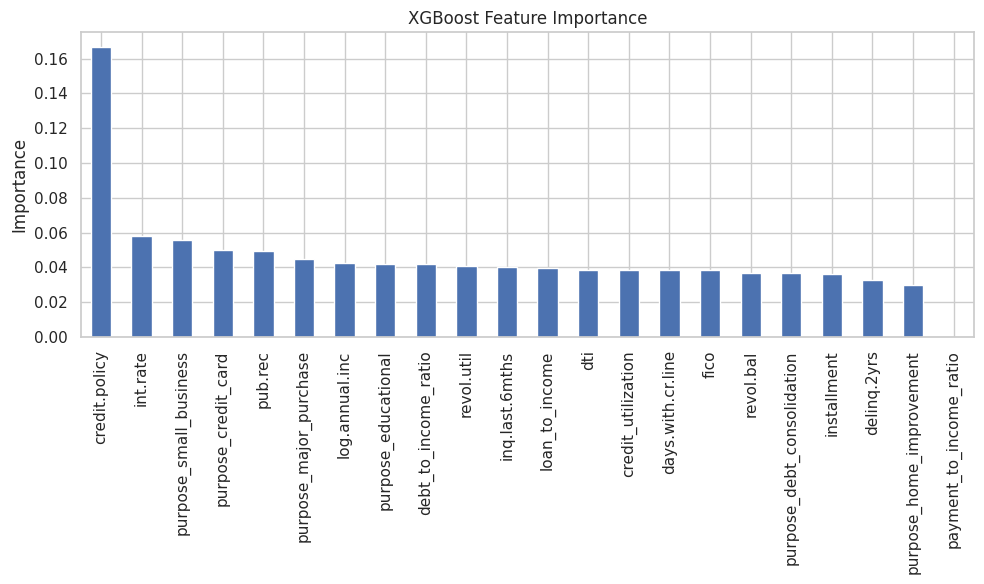


Gradient Boosting Feature Importance:
int.rate                      0.218574
credit.policy                 0.098215
loan_to_income                0.081136
log.annual.inc                0.079683
inq.last.6mths                0.077562
fico                          0.072039
days.with.cr.line             0.065656
revol.util                    0.053566
installment                   0.037699
revol.bal                     0.034741
dti                           0.033875
credit_utilization            0.026955
purpose_small_business        0.023893
purpose_credit_card           0.023749
purpose_debt_consolidation    0.020329
debt_to_income_ratio          0.018434
pub.rec                       0.015038
payment_to_income_ratio       0.009723
delinq.2yrs                   0.007285
purpose_home_improvement      0.001163
purpose_major_purchase        0.000684
purpose_educational           0.000000
dtype: float64


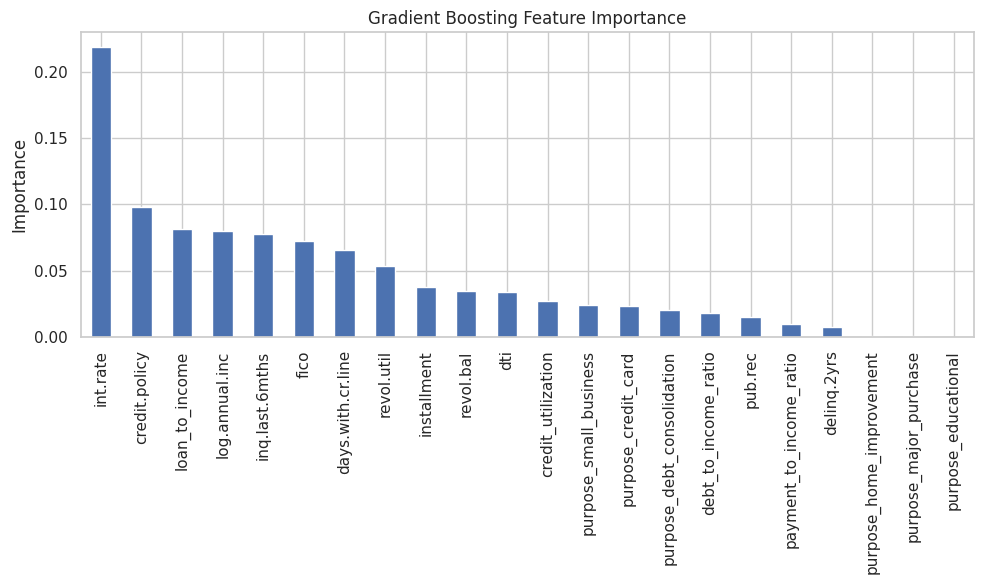


Fairness Analysis:

Fairness analysis for Logistic Regression:


ValueError: Found input variables with inconsistent numbers of samples: [1916, 3218]

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference

# Confusion Matrix
print("\nConfusion Matrices:")
for name, model in models.items():
    print(f"\n{name} Confusion Matrix:")
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Classification Report
print("\nClassification Reports:")
for name, model in models.items():
    print(f"\n{name} Classification Report:")
    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))

# ROC Curves
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

# Cross-Validation (Using the best model)
print(f"\nPerforming Cross-Validation for the best model: {best_model_name}")
best_model = models[best_model_name]
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC AUC scores: {cv_scores}")
print(f"Mean cross-validation ROC AUC: {cv_scores.mean():.4f}")
print(f"Standard deviation of cross-validation ROC AUC: {cv_scores.std():.4f}")

# Feature Importance (for tree-based models)
print("\nFeature Importance:")
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        print(f"\n{name} Feature Importance:")
        importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
        print(importance)

        plt.figure(figsize=(10, 6))
        importance.plot(kind='bar')
        plt.title(f'{name} Feature Importance')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()

# Fairness Analysis with Fairlearn
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ensure 'sensitive_attribute_name' exists in X_test_orig
if sensitive_attribute_name in X_test_orig.columns:
    A_test = X_test_orig[sensitive_attribute_name].reset_index(drop=True)
else:
    raise KeyError(f"Error: '{sensitive_attribute_name}' column not found in X_test_orig. Please check preprocessing steps.")

# Align indices between A_test and y_test
y_test = y_test.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

print("\nFairness Analysis:")
for name, model in models.items():
    print(f"\nFairness analysis for {name}:")
    y_pred = model.predict(X_test_scaled)

    fairness_metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score
    }

    # Compute fairness metrics separately
    dp_diff = demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test)
    eo_diff = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test)

    metric_frame = MetricFrame(metrics=fairness_metrics,
                               y_true=y_test,
                               y_pred=y_pred,
                               sensitive_features=A_test)

    print(metric_frame.by_group)

    metric_frame.by_group.plot(kind='bar', legend=True, figsize=(10, 6),
                               title=f'{name} Performance by {sensitive_attribute_name}')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(f"Demographic Parity Difference: {dp_diff:.4f}")
    print(f"Equalized Odds Difference: {eo_diff:.4f}")

print("\nEvaluation and Metrics Analysis Complete.")


Error Analysis

False Positives: 27 cases
False Negatives: 6 cases


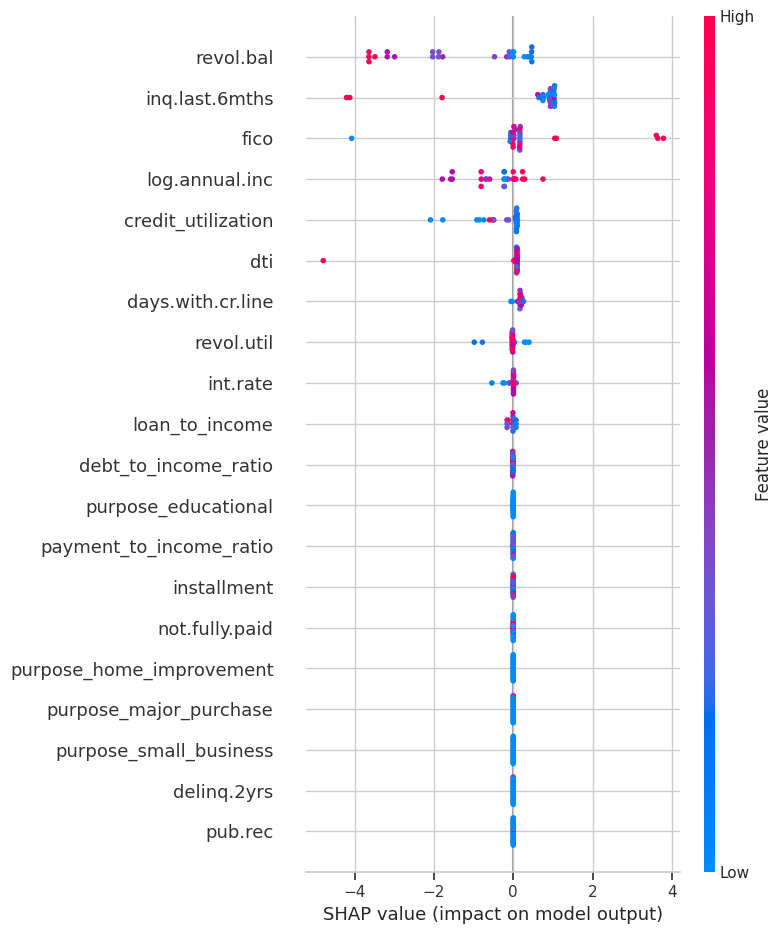

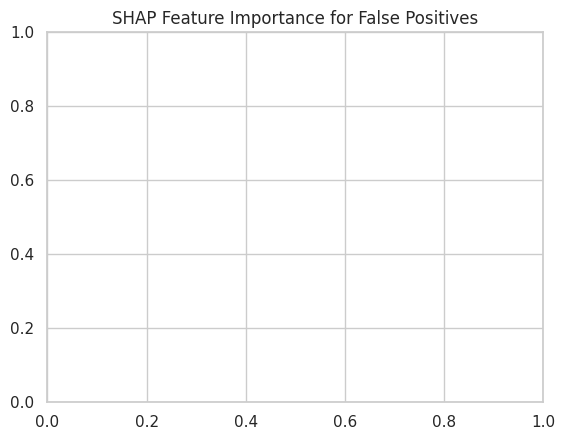

In [87]:
# Assuming data, X, y are already defined and preprocessed as in the original notebook cells

# Re-split the data just in case it was modified elsewhere
X = data.drop('credit.policy', axis=1)
y = data['credit.policy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate a model (e.g., the Gradient Boosting model that caused the error)
# In a real scenario, you would loop through models as in your previous cell
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
model.fit(X_train, y_train)

def error_analysis(model, X_test, y_test):
    """Analyze model errors and problematic cases"""

    # Make predictions and get probabilities BEFORE modifying X_test
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]

    # Create a new DataFrame or add columns to a copy of X_test for analysis
    X_test_analysis = X_test.copy() # Use a copy to avoid modifying the original X_test
    X_test_analysis['predicted'] = predictions
    X_test_analysis['probability'] = probabilities
    X_test_analysis['actual'] = y_test

    # False Positives (Predicted Converters that didn't)
    fp = X_test_analysis[(X_test_analysis['predicted'] == 1) & (X_test_analysis['actual'] == 0)].copy() # Use .copy() to avoid SettingWithCopyWarning
    print(f"False Positives: {len(fp)} cases")
    # False Negatives (Predicted Non-Converters that did)
    fn = X_test_analysis[(X_test_analysis['predicted'] == 0) & (X_test_analysis['actual'] == 1)].copy() # Use .copy()
    print(f"False Negatives: {len(fn)} cases")

    # Feature Importance for Error Cases (only if the model supports feature importance or SHAP)
    # Check if the model is tree-based for SHAP TreeExplainer
    if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier, DecisionTreeClassifier)):
        try:
            explainer = shap.TreeExplainer(model)
            # SHAP values for False Positives - exclude the added columns for shap analysis
            shap_values_fp = explainer.shap_values(fp.drop(['predicted', 'probability', 'actual'], axis=1))

            # For binary classification, TreeExplainer returns a list with two arrays.
            # shap_values[0] for class 0, shap_values[1] for class 1.
            # We are interested in why predictions were 1 (False Positives), so use shap_values[1]
            if isinstance(shap_values_fp, list): # shap_values is a list for multi-output models or specific explainers
                 shap_values_fp = shap_values_fp[1]

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values_fp, fp.drop(['predicted', 'probability', 'actual'], axis=1))
            plt.title('SHAP Feature Importance for False Positives')
            plt.show()
        except Exception as e:
            print(f"Could not generate SHAP plot: {e}")
            print("Ensure the 'shap' library is installed (`!pip install shap`) and the model is compatible with TreeExplainer.")

    else:
        print("SHAP TreeExplainer is typically used for tree-based models. Skipping SHAP analysis.")


    return fp, fn

# Call the error_analysis function with a trained model and the original X_test, y_test
# You would ideally do this after selecting your best model from the evaluation loop
fp_cases, fn_cases = error_analysis(model, X_test, y_test)

Performance Benchmarking


Model Benchmarking Results:
                 Model  CV Score (Mean)  CV Score (Std)  Test AUC
3              XGBoost         0.998295        0.000897  0.999078
1        Random Forest         0.996407        0.001506  0.997107
2    Gradient Boosting         0.996537        0.002242  0.996028
0  Logistic Regression         0.632548        0.013904  0.624361


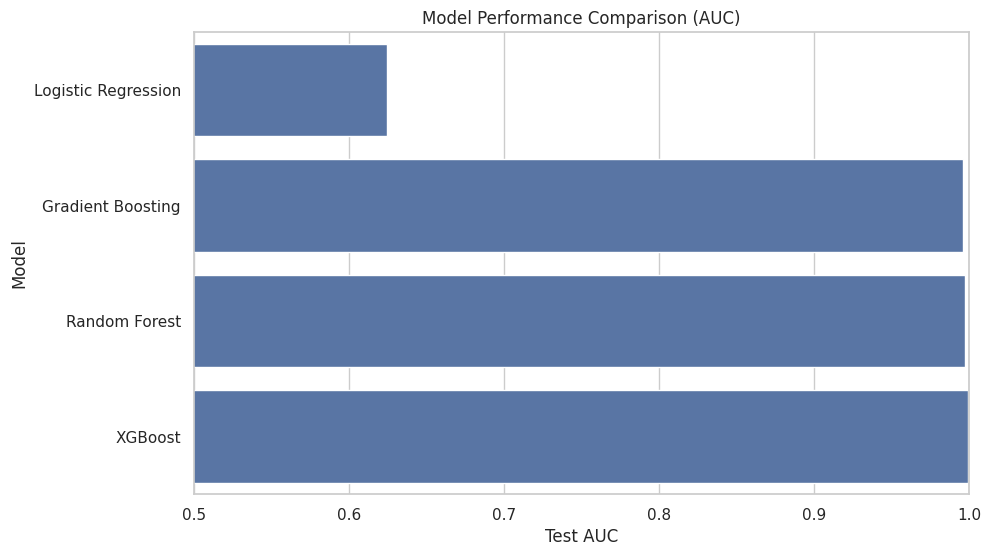

In [91]:
def benchmark_models(X_train, y_train, X_test, y_test):
    """Compare multiple models using cross-validation"""
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import GradientBoostingClassifier
    from xgboost import XGBClassifier
    from sklearn.model_selection import cross_val_score # Import cross_val_score
    from sklearn.metrics import roc_auc_score # Import roc_auc_score
    import pandas as pd # Import pandas
    import matplotlib.pyplot as plt # Import matplotlib.pyplot
    import seaborn as sns # Import seaborn

    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
    }

    results = pd.DataFrame(columns=['Model', 'CV Score (Mean)', 'CV Score (Std)', 'Test AUC'])

    for name, model in models.items():
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
         # Test set evaluation
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_proba)

        results.loc[len(results)] = [
            name,
            cv_scores.mean(),
            cv_scores.std(),
            test_auc
        ]

    # Display results
    print("\nModel Benchmarking Results:")
    print(results.sort_values('Test AUC', ascending=False))

    # Plot comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Test AUC', y='Model', data=results.sort_values('Test AUC'))
    plt.title('Model Performance Comparison (AUC)')
    # Correct indentation here
    plt.xlim(0.5, 1.0)
    plt.show()

    return results

benchmark_results = benchmark_models(X_train, y_train, X_test, y_test)